In [5]:
# Plot results 
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import sem

with open('data/maps.pkl', 'rb') as f:
    data = pickle.load(f)
    strategy_map = data['reviewer_to_strategy']
    
def my_bar(data, fname, xlabel, xticks, ylabel, ymax, color):
    plt.rcParams.update({'font.size': 12})
    scale = 2
    x = np.arange(0, scale*len(data), scale) 
    means = [np.mean(d) for d in data]
    errs = [sem(d) for d in data]
    plt.bar(x, means, yerr=errs, width=1.5, color=color)
    plt.xticks(x, xticks)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.ylim([0, ymax])
    plt.tight_layout()
    plt.savefig('plots/'+fname)
    plt.show()
    
strategy_labels = ['Basic', 'Negative-\nin-area', 'Overlap', 'Cycle', 'Popularity']

[11.  9.  3.  4.  2.] 2


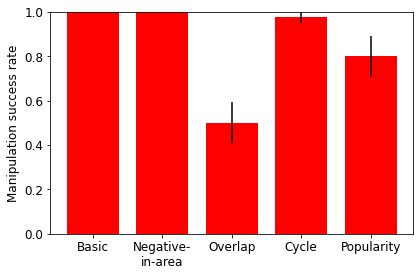

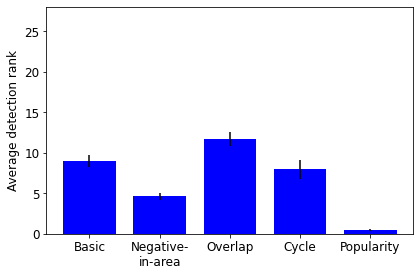

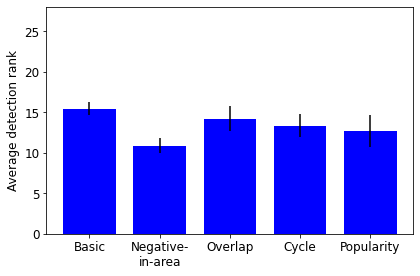

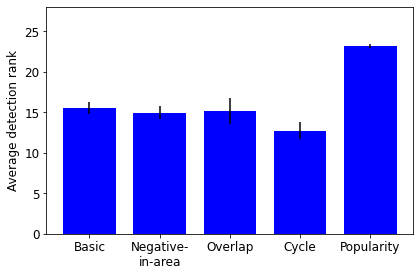

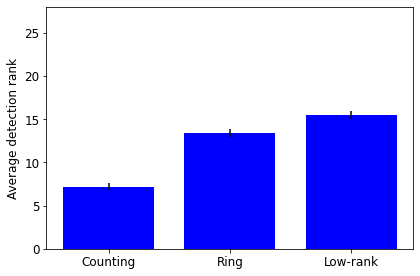

In [6]:
data = np.load('data/Result.npz')
success_by_reviewer=data['success_by_reviewer'].tolist()
rank_by_reviewer_simple=data['rank_by_reviewer_simple'].tolist()
rank_by_reviewer_cluster=data['rank_by_reviewer_cluster'].tolist()
rank_by_reviewer_low_rank=data['rank_by_reviewer_low_rank'].tolist()
num_trials = data['num_trials']

n_strat = 5
strategy_success = [[] for _ in range(n_strat)]
strategy_count = np.zeros(n_strat)
strategy_rank_simple = [[] for _ in range(n_strat)]
strategy_rank_cluster = [[] for _ in range(n_strat)]
strategy_rank_lowrank = [[] for _ in range(n_strat)]
rank_total = [[] for _ in range(3)]
non_count = 0
for r in range(len(success_by_reviewer)):
    strat = strategy_map[r]
    if strat < 0:
        non_count += 1
        continue
    strategy_count[strat] += 1
    c = int(success_by_reviewer[r])
    strategy_success[strat] += ([1] * c) + ([0] * (num_trials - c))
    strategy_rank_simple[strat] += rank_by_reviewer_simple[r]
    strategy_rank_cluster[strat] += rank_by_reviewer_cluster[r]
    strategy_rank_lowrank[strat] += rank_by_reviewer_low_rank[r]
    rank_total[0] += rank_by_reviewer_simple[r]
    rank_total[1] += rank_by_reviewer_cluster[r]
    rank_total[2] += rank_by_reviewer_low_rank[r]
    
print(strategy_count, non_count)
    
my_bar(strategy_success, 'success.pdf', '', strategy_labels, 'Manipulation success rate', 1, color='red')
my_bar(strategy_rank_simple, 'rank_simple.pdf', '', strategy_labels, 'Average detection rank', 28, color='blue')
my_bar(strategy_rank_cluster, 'rank_cluster.pdf', '', strategy_labels, 'Average detection rank', 28, 'blue')
my_bar(strategy_rank_lowrank, 'rank_lowrank.pdf', '', strategy_labels, 'Average detection rank', 28, 'blue')
my_bar(rank_total, 'rank_algos.pdf', '', ['Counting', 'Ring', 'Low-rank'], 'Average detection rank', 28, 'blue')

In [7]:
data = np.load('data/Result_synth.npz')
success_by_strategy_list=data['success_by_strategy'].tolist()
rank_by_strategy_simple_list=data['rank_by_strategy_simple'].tolist()
rank_by_strategy_cluster_list=data['rank_by_strategy_cluster'].tolist()
rank_by_strategy_low_rank_list=data['rank_by_strategy_low_rank'].tolist()
num_trials = data['num_trials']
group_size = data['group_size']
N = data['n']
nstrat = 4

success_by_strategy = [[] for _ in range(nstrat)]
rank_by_strategy_simple = [[] for _ in range(nstrat)]
rank_by_strategy_cluster = [[] for _ in range(nstrat)]
rank_by_strategy_low_rank = [[] for _ in range(nstrat)]
for i in range(nstrat): # list of num_trials # successes in group
    for j in range(num_trials):
        s = int(success_by_strategy_list[i][j])
        samples = ([1] * s) + ([0] * (group_size - s))
        success_by_strategy[i] += samples
        rank_by_strategy_simple[i] += rank_by_strategy_simple_list[i][j]
        rank_by_strategy_cluster[i] += rank_by_strategy_cluster_list[i][j]
        rank_by_strategy_low_rank[i] += rank_by_strategy_low_rank_list[i][j]

my_bar(success_by_strategy[:nstrat], 'success_synth.pdf', '', strategy_labels[:nstrat], 'Manipulation success rate', 1, 'red')
my_bar(rank_by_strategy_simple[:nstrat], 'rank_simple_synth.pdf', '', strategy_labels[:nstrat], 'Average detection rank', N, 'blue')
my_bar(rank_by_strategy_cluster[:nstrat], 'rank_cluster_synth.pdf', '', strategy_labels[:nstrat], 'Average detection rank', N, 'blue')
my_bar(rank_by_strategy_low_rank[:nstrat], 'rank_lowrank_synth.pdf', '', strategy_labels[:nstrat], 'Average detection rank', N, 'blue')

FileNotFoundError: [Errno 2] No such file or directory: 'data/Result_synth.npz'

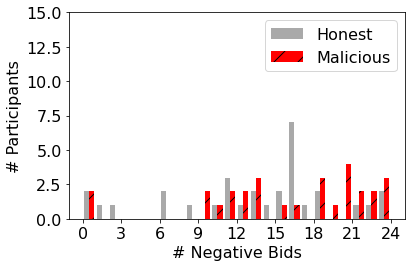

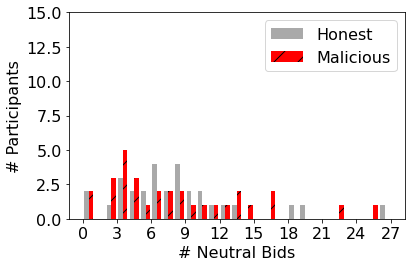

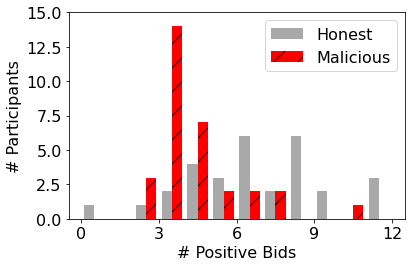

In [9]:
# Plot histograms of +/-/0 malicious reviewer bids

data = np.load('data/Biddings.npz')
HB = data['HB']
MB = data['MB']
honest_counts = {}
malicious_counts = {}
for bid, label in zip([-1, 0, 1], ['Negative', 'Neutral', 'Positive']):
    h_counts = np.sum(HB == bid, axis=1)
    honest_counts[bid] = h_counts.tolist()
    m_counts = np.sum(MB == bid, axis=1)
    malicious_counts[bid] = m_counts.tolist()
    h_count_counts = []
    m_count_counts = []
    max_val = 0
    for i in range(29):
        h_count_counts.append(np.sum(h_counts == i))
        m_count_counts.append(np.sum(m_counts == i))
    
    plt.rcParams.update({'font.size': 16})
    max_val = max([i for i in range(29) if h_count_counts[i] + m_count_counts[i] > 0])
    n , bins, patches = plt.hist([h_counts, m_counts], np.arange(max_val),  label=['Honest', 'Malicious'], color=['darkgrey', 'red'], hatch='/')
    for patch_set, hatch in zip(patches, ['', '/']):
        plt.setp(patch_set, hatch=hatch)
    plt.xlabel(f'# {label} Bids')
    plt.ylabel('# Participants')
    plt.ylim([0, 15])
    plt.xticks(np.arange(0, max_val, 3))
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f'plots/bid_dist_{bid}.pdf')
    plt.show()

In [39]:
## Do some strategy analysis
import csv

with open('data/maps.pkl', 'rb') as f:
    data = pickle.load(f)
    strategy_map = data['reviewer_to_strategy']
    strat_descs = data['strategy_descriptions']
    author_map_group = data['author_map_group']
    target_map = data['target_map']
    author_map = data['author_map']
    
data = np.load('data/Biddings.npz')
MB = data['MB']
SA = data['SA']
    
with open('data/strat_analysis.csv', 'w') as f:
    f.write('strat\tdesc\ttarget bids\tsim pos\tsim neg\tsim neut\tnon pos\tnon neg\tnon neut\n')
    for rid in range(31):
        strat = strategy_map[rid]
        desc = strat_descs[rid].replace('\t', ' ').replace('\n', ' ')
        if rid in target_map:
            target = [target_map[rid]]
        else:
            target = author_map_group[rid].copy()
            authored = author_map[rid]
            target.remove(authored)
        SA_row = SA[rid, :]
        B_row = MB[rid, :]
        papers_sim = [x[0] for x in np.argwhere(SA_row > 0) if x[0] not in target] 
        papers_non = [x[0] for x in np.argwhere(SA_row == 0) if x[0] not in target]
        target_bids = B_row[target].tolist()
        pos = B_row == 1
        neg = B_row == -1
        neut= B_row == 0
        npos = [np.sum(pos[papers_sim]), np.sum(pos[papers_non])]
        nneg = [np.sum(neg[papers_sim]), np.sum(neg[papers_non])]
        nneut = [np.sum(neut[papers_sim]), np.sum(neut[papers_non])]
        f.write(f'{strat}\t{desc}\t{target_bids}\t{npos[0]}\t{nneg[0]}\t{nneut[0]}\t{npos[1]}\t{nneg[1]}\t{nneut[0]}\n')